In [3]:
#import
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election, metrics)
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from functools import partial
import pandas
import networkx as nx
import numpy as np
import geopandas as gpd
import shapely
from scipy.stats.stats import pearsonr

In [4]:
#load the dual graph
graph = Graph.from_file("./PA_VTD/PA_VTD.shp")
gdf = gpd.read_file("./PA_VTD/PA_VTD.shp")

In [5]:
#elections and updaters
pop_col = "TOT_POP"
election_names = [
    "PRES12",
    "PRES16",
    "SENW101216",
]
election_columns = [
    ["PRES12D", "PRES12R"],
    ["T16PRESD", "T16PRESR"],
    ["W101216D", "W101216R"],
]
updaters1 = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(len(election_names))
]
election_updaters = {election.name: election for election in elections}
updaters1.update(election_updaters)

In [6]:
#fix some strings which should be numbers
for n in graph.nodes():
    graph.nodes[n]['538CPCT__1'] = int(graph.nodes[n]['538CPCT__1'])
    graph.nodes[n]['538DEM_PL'] = int(graph.nodes[n]['538DEM_PL'])
    graph.nodes[n]['538GOP_PL'] = int(graph.nodes[n]['538GOP_PL'])
    graph.nodes[n]['8THGRADE_1'] = int(graph.nodes[n]['8THGRADE_1'])

In [7]:
#real partitions
partition_2011 = Partition(graph, "2011_PLA_1", updaters1)
partition_GOV = Partition(graph, "GOV", updaters1)
partition_TS = Partition(graph, "TS", updaters1)
partition_REMEDIAL = Partition(graph, "REMEDIAL_P", updaters1)
partition_CPCT = Partition(graph, "538CPCT__1", updaters1)
partition_DEM = Partition(graph, "538DEM_PL", updaters1)
partition_GOP = Partition(graph, "538GOP_PL", updaters1)
partition_8th = Partition(graph, "8THGRADE_1", updaters1)
partition_list = [
    partition_2011, partition_GOV, partition_TS, partition_REMEDIAL, partition_CPCT, partition_DEM, partition_GOP, partition_8th]
label_list = [
    '2011', 'GOV', 'TS', 'REMEDIAL', 'CPCT','DEM', 'GOP','8th']
ideal_population = sum(partition_2011["population"].values())/len(partition_2011)
print("Ideal population: ", ideal_population)

Ideal population:  704718.2777777778


In [8]:
#ReCom run setup
proposal = partial(recom,
                   pop_col="TOT_POP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(partition_2011["cut_edges"])
)
pop_constraint = constraints.within_percent_of_ideal_population(partition_2011, 0.15)
chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=partition_2011,
    total_steps=1000
)

In [9]:
def ccs_over_districts(part, threshold, subgraph_ccs=None):
    cc_splits = 0
    ccs = 0
    if (subgraph_ccs==None):
        graph = part.graph
        nodes_over_threshold = []
        for i in graph.nodes:
            if float(graph.nodes[i]["PRES12D"])+float(graph.nodes[i]["PRES12R"]) != 0:
                if graph.nodes[i]["PRES12D"]/(
                    graph.nodes[i]["PRES12D"]+graph.nodes[i]["PRES12R"]) > threshold:
                    nodes_over_threshold.append(i)
        subgraph = graph.subgraph(nodes_over_threshold)
        connected_components = nx.connected_components(subgraph)
    else:
        connected_components = subgraph_ccs
    for cc in connected_components:
        ccs+=1
        for district in part.assignment.parts:
            if len(cc & part.assignment.parts[district]) != 0:
                cc_splits +=1
    return cc_splits-ccs


In [10]:
def draw_blue_islands(graph, gdf, threshold):
    ass = {x:1 for x in graph.nodes}
    nodes_over_threshold = []
    for i in graph.nodes:
        if float(graph.nodes[i]["PRES12D"])+float(graph.nodes[i]["PRES12R"]) != 0:
            if graph.nodes[i]["PRES12D"]/(
                graph.nodes[i]["PRES12D"]+graph.nodes[i]["PRES12R"]) > threshold:
                nodes_over_threshold.append(i)
    subgraph = graph.subgraph(nodes_over_threshold)
    connected_components = nx.connected_components(subgraph)
    for cc in connected_components:
        for node in cc:
            ass[node]=0
    part = GeographicPartition(graph, ass)
    part.plot(gdf, cmap='seismic')

In [11]:
xvals = [x/100 for x in range(0,100)]
subgraph_ccs = {}
for x in xvals:
    nodes_over_threshold = []
    for i in graph.nodes:
        if float(graph.nodes[i]["T16PRESD"])+float(graph.nodes[i]["T16PRESR"]) != 0:
            if graph.nodes[i]["T16PRESD"]/(
                graph.nodes[i]["T16PRESD"]+graph.nodes[i]["T16PRESR"]) > x:
                nodes_over_threshold.append(i)
    subgraph = graph.subgraph(nodes_over_threshold)
    subgraph_ccs_gen = nx.connected_components(subgraph)
    subgraph_ccs[x] = [c for c in subgraph_ccs_gen if sum(
        [graph.nodes[n][pop_col] for n in c]) > 0.05*ideal_population]

Threshold =  0.95 , components =  2


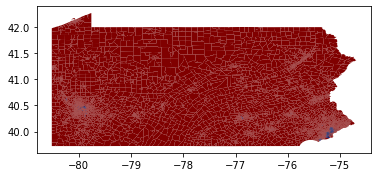

Threshold =  0.9 , components =  3


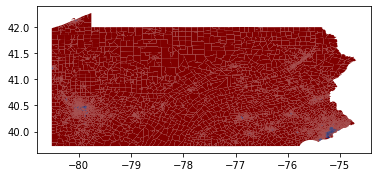

Threshold =  0.85 , components =  2


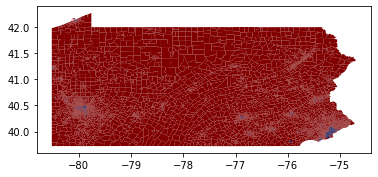

Threshold =  0.8 , components =  5


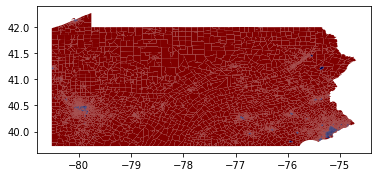

Threshold =  0.75 , components =  6


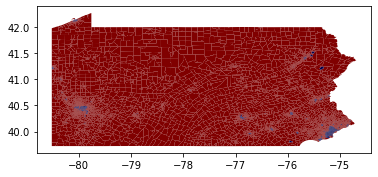

Threshold =  0.7 , components =  9


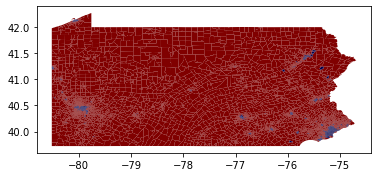

Threshold =  0.65 , components =  12


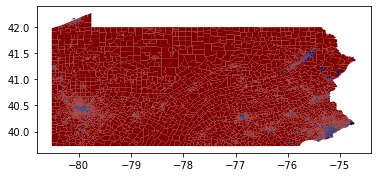

Threshold =  0.6 , components =  12


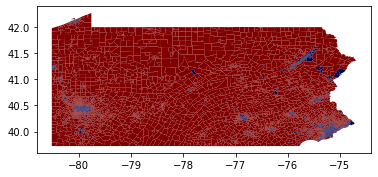

Threshold =  0.55 , components =  14


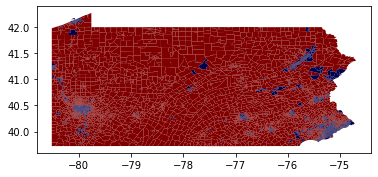

Threshold =  0.5 , components =  15


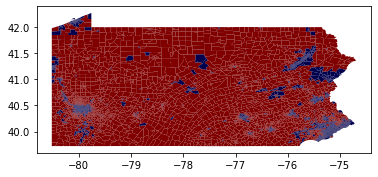

KeyError: 0.44999999999999996

In [12]:
for x in [1-x/20 for x in range(1,15)]:
    print("Threshold = ", round(x,2), ", components = ", len(subgraph_ccs[x]))
    draw_blue_islands(graph, gdf, x)
    plt.show()

In [ ]:
timer = 0
xvals = [x/100 for x in range(0,100)]
data = {x:[] for x in xvals}
seats = []
for state in chain:
    timer+=1
    if (timer %100 == 0):
        print(timer, end=" ")
    for x in xvals:
        data[x].append(ccs_over_districts(state, x, subgraph_ccs=subgraph_ccs[x]))
    seats.append(state['PRES16'].seats('Democratic'))

In [ ]:
xvals = [x/100 for x in range(60,90)]

plt.hist(seats)
print("2011 Dem seats:", partition_2011['PRES16'].seats('Democratic'))
plt.show()

plt.figure(figsize=(8,8))

'''
for i in range(min(seats), max(seats)+1):
    data_means = []
    for x in xvals:
        data_means.append(
            np.mean([data[x][z] for z in range(len(data[x])) if seats[z]==i]))
    plt.plot(xvals, data_means, label="ReCom samples with "+str(i)+" DEM seats.")
'''

data_means = []
for x in xvals:
    data_means.append(
        np.mean([data[x][z] for z in range(len(data[x]))]))
plt.plot(xvals, data_means, label="ReCom means")

for k in [0,2,5,6]:
    list1 = []
    for i in xvals:
        list1.append(ccs_over_districts(partition_list[k], i, subgraph_ccs=subgraph_ccs[i]))
    plt.plot(xvals, list1, label=label_list[k])
    plt.legend(loc='lower left')
plt.legend(loc='best')
plt.xlabel("Filter level (min DEM share to be included)")
plt.ylabel("Average districts intersecting connected component")
    

In [ ]:
partition_2011.plot(gdf)
plt.show()
plt.scatter(range(1,19), sorted(partition_2011['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()
partition_GOP.plot(gdf)
plt.show()
plt.scatter(range(1,19), sorted(partition_GOP['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()
partition_TS.plot(gdf)
plt.show()
plt.scatter(range(1,19), sorted(partition_TS['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()
partition_DEM.plot(gdf)
plt.show()
plt.scatter(range(1,19), sorted(partition_DEM['PRES16'].percents('Democratic')))
plt.hlines(0.5, 1, 19)
plt.show()


### Vector of intersections

In [13]:
#districts intersected by cc
def splits_by_cc(part, cc_list):
    cc_splits = np.zeros(len(cc_list))
    for cc in range(len(cc_list)):
        for d in part.parts:
            if len(cc_list[cc] & part.assignment.parts[d]) != 0:
                cc_splits[cc]+=1
    return cc_splits

100 200 300 400 500 600 700 800 900 1000 

(array([322.,   0.,   0.,   0.,   0., 468.,   0.,   0.,   0., 210.]),
 array([6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6, 7.8, 8. ]),
 <a list of 10 Patch objects>)

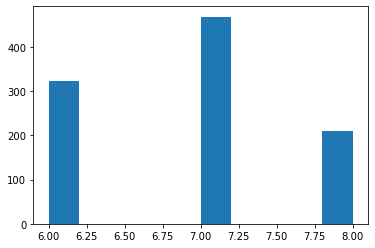

In [14]:
timer = 0
xvals = [x/20 for x in range(2,18)]
data = {x:[] for x in xvals}
seats = []
for state in chain:
    timer+=1
    if (timer %100 == 0):
        print(timer, end=" ")
    for x in xvals:
        data[x].append(splits_by_cc(state, subgraph_ccs[x]))
    seats.append(state['PRES16'].seats('Democratic'))
plt.hist(seats)

In [15]:
data_means = {}
data_std = {}
for x in xvals:
    data_means[x] = np.zeros(len(subgraph_ccs[x]))
    for i in range(len(data_means[x])):
        data_means[x][i] = np.mean([z[i] for z in data[x]])
    print(x, " mean vector: ", data_means[x])
    data_std[x] = np.mean(
        [np.linalg.norm(data_means[x]-v) for v in data[x] ]
    )
    print(x, " mean deviation: ", data_std[x])

0.1  mean vector:  [18.]
0.1  mean deviation:  0.0
0.15  mean vector:  [18.]
0.15  mean deviation:  0.0
0.2  mean vector:  [18.    1.13]
0.2  mean deviation:  0.22619999999999993
0.25  mean vector:  [ 2.224  5.761  1.123 12.883  1.182  1.259  1.584  2.698  2.024  1.13 ]
0.25  mean deviation:  1.572791015915113
0.3  mean vector:  [ 1.489 10.819  1.777  1.243  4.495  3.261  1.442  1.213  2.346  1.349
  1.612  1.02   1.13   1.368]
0.3  mean deviation:  1.9356609198352244
0.35  mean vector:  [8.831 2.127 2.651 4.27  1.31  2.255 1.076 2.298 1.531 1.211 1.41  1.393]
0.35  mean deviation:  1.8574988714740193
0.4  mean vector:  [8.488 1.79  1.272 1.943 2.123 4.221 1.941 1.984 1.211 1.054 1.14 ]
0.4  mean deviation:  1.7472580188046762
0.45  mean vector:  [2.283 7.402 1.493 2.038 3.837 1.872 1.682 1.714 1.402 1.211 1.186 1.134
 1.182]
0.45  mean deviation:  1.8572863206590333
0.5  mean vector:  [3.21  2.145 1.334 6.93  1.959 1.832 1.395 1.326 1.557 1.261 1.283 1.131
 1.101 1.134 1.179]
0.5  mea

Text(0, 0.5, 'Distance from ReCom mean')

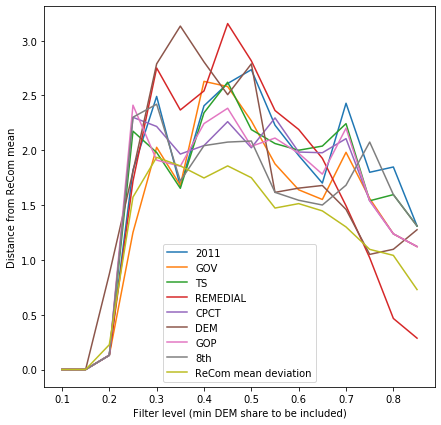

In [16]:
plt.figure(figsize=(7,7))
for k in range(len(partition_list[0:8])):
    deviations = []
    for x in xvals:
        deviations.append(np.linalg.norm(
            splits_by_cc(partition_list[k],subgraph_ccs[x])-data_means[x]))
    plt.plot(xvals, deviations, label=label_list[k])
plt.plot(xvals, [data_std[x] for x in xvals], label="ReCom mean deviation")
plt.legend(loc='best')
plt.xlabel("Filter level (min DEM share to be included)")
plt.ylabel("Distance from ReCom mean")

In [29]:
for x in [0.8]:
    print(data_means[x])
    print(splits_by_cc(partition_2011,subgraph_ccs[x])-data_means[x])
    print(splits_by_cc(partition_DEM,subgraph_ccs[x])-data_means[x])

[2.157 1.14  4.007 1.066 1.41 ]
[-1.157 -0.14  -1.007  0.934 -0.41 ]
[-0.157 -0.14   0.993 -0.066 -0.41 ]


Cc with 2011 plan big split deviation:


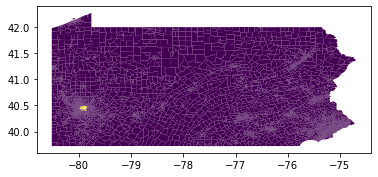

In [30]:
ass = {n:0 for n in graph.nodes()}
x = 0.8
for n in graph.nodes():
    if n in subgraph_ccs[x][0]:
        ass[n] = 1
geog = GeographicPartition(graph, ass, updaters=None)
print("Cc with 2011 plan big split deviation:")
geog.plot(gdf)

Cc with 2011 plan big split deviation:


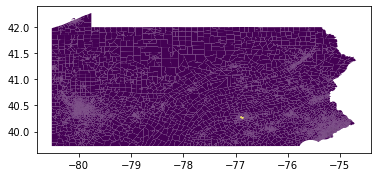

In [31]:
ass = {n:0 for n in graph.nodes()}
x = 0.8
for n in graph.nodes():
    if n in subgraph_ccs[x][3]:
        ass[n] = 1
geog = GeographicPartition(graph, ass, updaters=None)
print("Cc with 2011 plan big split deviation:")
geog.plot(gdf)

Cc with 2011 plan big split deviation:


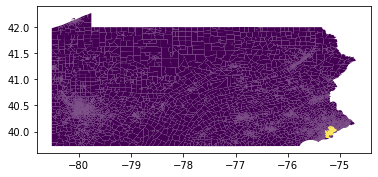

In [32]:
ass = {n:0 for n in graph.nodes()}
x = 0.8
for n in graph.nodes():
    if n in subgraph_ccs[x][2]:
        ass[n] = 1
geog = GeographicPartition(graph, ass, updaters=None)
print("Cc with 2011 plan big split deviation:")
geog.plot(gdf)

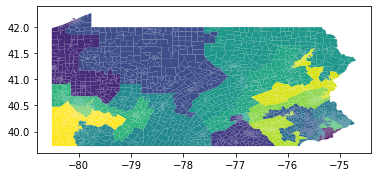

In [33]:
partition_2011.plot(gdf)

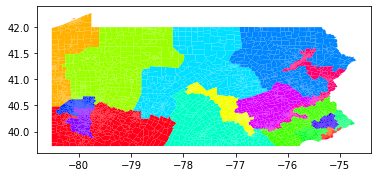

In [38]:
partition_DEM.plot(gdf, cmap="hsv")